In [2]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)

from time import time_ns
from amftrack.util.dbx import (
    upload_folders,
    load_dbx,
    download,
    get_dropbox_folders_prince,
)
from datetime import datetime
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.dbx import read_saved_dropbox_state, get_dropbox_folders_prince
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from matplotlib import cm
from matplotlib.patches import Rectangle
from amftrack.transport.align_video_network import identify_nodes, selected_rectangle
from IPython.display import clear_output
import re

import sys
import os
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from tifffile import imwrite
from tqdm import tqdm
import scipy
import matplotlib as mpl
from pathlib import Path
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
import dropbox
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from subprocess import call
import logging
import datetime
import glob
import json
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.util.dbx import upload
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiPolygon
from shapely import affinity
from random import randint
import cv2
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from amftrack.notebooks.P_experiment.helper import (
    get_polygons,
    create_polygon,
    get_regions,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    make_full_image,
    plot_full_video,
)

mpl.rcParams["figure.dpi"] = 60

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plates = ["532_20220104"]

In [12]:
directory_targ = os.path.join(directory_scratch, "stitch_temp") + "/"
directory_targ = directory_project

update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/4218 [00:00<?, ?it/s]

In [13]:
folders = all_folders.loc[all_folders["unique_id"] == plates[0]]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]

In [8]:
all_folders["unique_id"].unique()

array(['532_20220104', '441_20230807', '800_20210928', '772_20230317',
       '771_20230411', '84_20220621', '777_20230328', '764_20221219',
       '33_20220502', '449_20230807', '1014_20220525', '12_20220502',
       '720_20221110', '218_20230227', '762_20221213', '13_20220422',
       '414_20230814', '21_20220502', '763_20230109', '941_20220404',
       '1042_20220523', '30_20220509', '713_20221108', '32_20220428',
       '737_20221025', '3_20220426', '734_20221019', '16_20220419',
       '884_20230522', '52_20220707', '130_20220707', '127_20220705',
       '480_20221205', '202_20230314', '545_20220115'], dtype=object)

In [14]:
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 40
exp.load(folders.iloc[i : i + 1], suffix="_width")
for t in range(exp.ts):
    exp.load_tile_information(t)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-01-07 19:55:00


In [30]:
exp.save_location = ""
nodes = get_all_nodes(exp, t)
in_ROIs = [node for node in nodes if not is_in_ROI_node(node, t)]

In [28]:
len(in_ROIs) / len(nodes)

0.8923343302376829

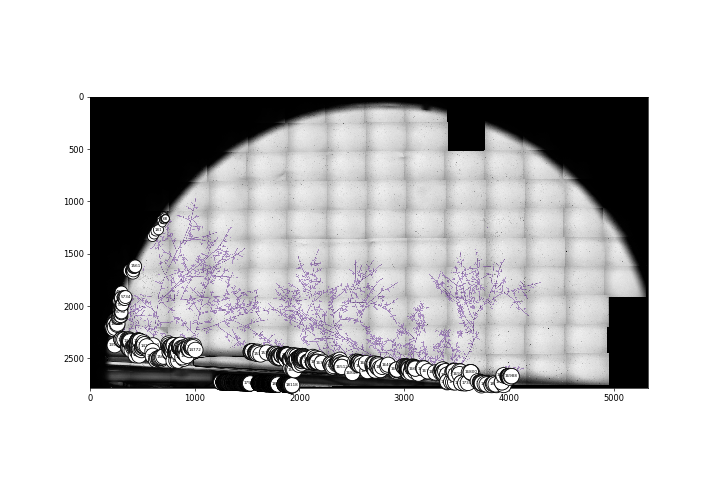

In [31]:
dpi = 400

vmax = 1
vmin = 0
downsizing = 10
fig, ax = plot_edge_color_value(
    exp,
    0,
    lambda edge: 1,
    cmap=cm.get_cmap("seismic", 100),
    v_min=vmin,
    v_max=vmax,
    show_background=True,
    dilation=5,
    figsize=(12, 8),
    downsizing=downsizing,
    nodes=in_ROIs,
)

In [5]:
update_analysis_info(directory_targ)
analysis_info = get_analysis_info(directory_targ)
analysis_folders = analysis_info.loc[analysis_info["unique_id"].isin(plates)]

In [11]:
import sys
from amftrack.util.sys import (
    update_analysis_info,
    get_analysis_info,
)
from amftrack.pipeline.launching.run_super import run_parallel_post
from amftrack.pipeline.functions.post_processing.global_plate import *
from amftrack.pipeline.functions.post_processing.time_plate import *
from amftrack.pipeline.functions.post_processing.global_hypha import *
from amftrack.pipeline.functions.post_processing.area_hulls import *
from amftrack.pipeline.launching.run_super import run_parallel, run_launcher
from amftrack.pipeline.functions.post_processing.exp_plot import *

time = "2:00:00"
list_f = [plot_hulls]
directory = directory_targ
name_job = "plot_hulls"
list_args = [[]] * len(list_f)
overwrite = True
num_parallel = 6
run_parallel_post(
    "exp_plot.py",
    list_f,
    list_args,
    [directory, overwrite],
    analysis_folders,
    num_parallel,
    time,
    "global_plate_post_process",
    cpus=128,
    name_job=name_job,
    node="fat",
)

sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 8 jobs.
sbatch: By default shared jobs get 7680 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1.0 node, based on the number of CPUs, GPUs and the amount memory that you've requested.


Submitted batch job 3909284


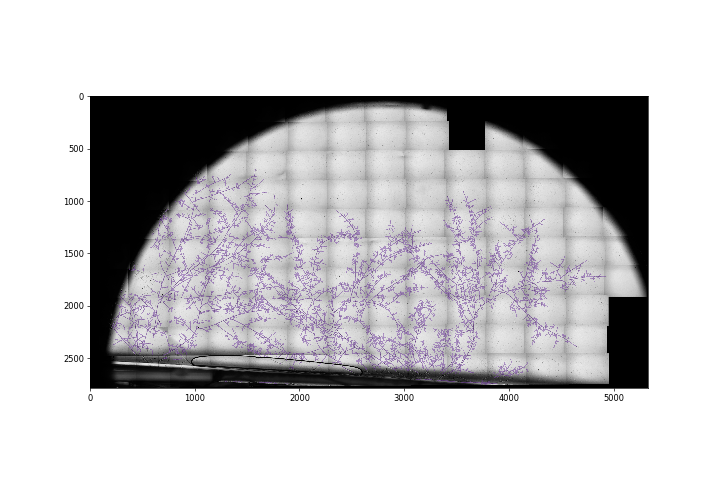

In [10]:
dpi = 400

vmax = 1
vmin = 0
downsizing = 10
fig, ax = plot_edge_color_value(
    exp,
    0,
    lambda edge: 1,
    cmap=cm.get_cmap("seismic", 100),
    v_min=vmin,
    v_max=vmax,
    show_background=True,
    dilation=5,
    figsize=(12, 8),
    downsizing=downsizing,
)

In [133]:
t = 0
im, skel_im = make_full_image(exp, t, downsizing=1000, dilation=5, edges=[])

NameError: name 'polygons' is not defined

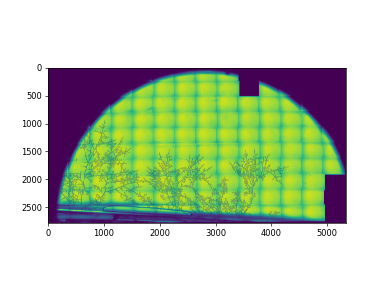

In [23]:
fig, ax = plt.subplots()
t = 0

im, skel_im = make_full_image(
    exp, t, downsizing=10, dilation=5, edges=get_all_edges(exp, t)
)
ax.imshow(im)

ax.imshow(skel_im, alpha=0.5)
for i, polygon in enumerate(polygons):
    # Extract the x and y coordinates
    polygon = affinity.scale(polygon, xfact=100, yfact=100, origin=(0, 0))
    x, y = polygon.exterior.xy

    # Plot the polygon
    ax.fill(x, y, alpha=0.1, fc="b", label=f"Polygon {i}")
    ax.plot(x, y, "r")
    centroid = polygon.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=12, ha="center", va="center")

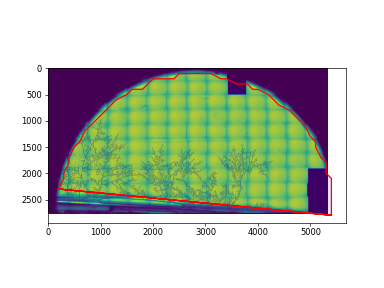

In [26]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_all_nodes,
    get_ROI,
)

polygon = get_ROI(exp, t)
polygon = Polygon(polygon)
polygon = affinity.scale(polygon, xfact=0.1, yfact=0.1, origin=(0, 0))

fig, ax = plt.subplots()
ax.imshow(im)
ax.imshow(skel_im, alpha=0.5)

x, y = polygon.exterior.xy

# Plot the polygon
ax.fill(x, y, alpha=0.1, fc="b", label=f"Polygon {i}")
ax.plot(x, y, "r")

In [34]:
polygon_geojson = polygon.__geo_interface__

# Save the GeoJSON to a file
with open("polygon.geojson", "w") as geojson_file:
    json.dump(polygon_geojson, geojson_file)

In [35]:
from shapely.geometry import shape
import json

# Open the GeoJSON file
with open("polygon.geojson", "r") as geojson_file:
    polygon_geojson = json.load(geojson_file)

# Create a Shapely Polygon from the GeoJSON dictionary
polygon = shape(polygon_geojson)

In [50]:
densities = [get_length_density_in_region(exp, t, {"i": i})[1] for i in range(18)]

NameError: name 'get_length_density_in_region' is not defined

In [ ]:
min_density = min(densities)
max_density = max(densities)
norm_densities = [
    (density - min_density) / (max_density - min_density) for density in densities
]

# Create a colormap
colormap = plt.cm.get_cmap("viridis")  # Choose any available colormap
fig, ax = plt.subplots()

# Your code for image generation
t = 0
im, skel_im = make_full_image(
    exp, t, downsizing=10, dilation=5, edges=get_all_edges(exp, t)
)
ax.imshow(skel_im)

for i, (polygon, density) in enumerate(zip(polygons, norm_densities)):
    # Extract the x and y coordinates
    polygon = affinity.scale(polygon, xfact=100, yfact=100, origin=(0, 0))
    x, y = polygon.exterior.xy

    # Get the color corresponding to the density
    color = colormap(density)

    # Plot the polygon
    ax.fill(x, y, alpha=0.1, fc=color, label=f"Polygon {i}")
    ax.plot(x, y, "r")
    centroid = polygon.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=12, ha="center", va="center")

plt.show()

In [64]:
from shapely.geometry import Polygon, LineString, MultiPolygon
from random import randint
import cv2
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_util import (
    make_full_image,
    plot_full_video,
)


def create_polygon(center_x, center_y, angle, scale):
    angle_rad = np.radians(angle)

    # Sector parameters
    radius = 45
    arc_points = 50

    # Calculate start and end angles for the arc
    theta1 = np.arccos((radius - 41) / radius)
    theta2 = -theta1
    thetas = np.linspace(theta1, theta2, arc_points)

    # Create vertices along the arc
    arc_x = center_x + radius * np.cos(thetas)
    arc_y = center_y + radius * np.sin(thetas)
    arc = np.column_stack((arc_x, arc_y))

    # Create straight edges
    edge1 = [center_x + radius * np.cos(theta1), center_y + radius * np.sin(theta1)]
    edge2 = [center_x + radius * np.cos(theta2), center_y + radius * np.sin(theta2)]
    edges = np.array([edge1, edge2])

    # Combine arc and edges
    vertices = np.vstack((arc, edges)) * scale

    # Rotate the vertices
    R = np.array(
        [
            [np.cos(angle_rad), -np.sin(angle_rad)],
            [np.sin(angle_rad), np.cos(angle_rad)],
        ]
    )
    rotated_vertices = vertices.dot(R.T)

    # Translate the vertices
    translated_vertices = rotated_vertices + [center_x, center_y]

    return translated_vertices.astype(int), angle_rad, [center_x, center_y]


# Your existing create_polygon function here...
# ...


def find_intersection(p1, p2, point_on_line, direction):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = point_on_line
    dx, dy = direction

    denom = dx * (y2 - y1) - dy * (x2 - x1)

    if denom == 0:
        return None

    t = ((x1 - x3) * dy - (y1 - y3) * dx) / denom
    u = -((x1 - x3) * (y2 - y1) - (y1 - y3) * (x2 - x1)) / denom

    if 0 <= t <= 1:
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)
        return np.array([x, y])
    else:
        return None


def slice_polygon(vertices, points_on_lines, direction):
    intersections = []

    for point in points_on_lines:
        for i in range(len(vertices) - 1):
            p1 = vertices[i]
            p2 = vertices[i + 1]

            intersection = find_intersection(p1, p2, point, direction)

            if intersection is not None:
                intersections.append(intersection)

    return np.array(intersections)


def interpolate_edge_points(edge1, edge2, t_values):
    interpolated_points = np.array(
        [(1 - t) * np.array(edge1) + t * np.array(edge2) for t in t_values]
    )
    return interpolated_points


def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    dx1 = x2 - x1
    dy1 = y2 - y1
    dx2 = x4 - x3
    dy2 = y4 - y3
    det = dx1 * dy2 - dx2 * dy1
    if det == 0:
        return None  # Lines are parallel or coincident
    t1 = ((x3 - x1) * dy2 - (y3 - y1) * dx2) / det
    t2 = ((x3 - x1) * dy1 - (y3 - y1) * dx1) / det
    if 0 <= t1 <= 1 and 0 <= t2 <= 1:
        # Intersection point is within both line segments
        intersection_x = x1 + t1 * dx1
        intersection_y = y1 + t1 * dy1
        return (intersection_x, intersection_y)
    return None  # No intersection


def get_polygons(center_x, center_y, angle, scale):
    # center_x, center_y = 0, 0
    # angle = 0  # Insert angle in degrees
    vertices, R, t = create_polygon(center_x, center_y, angle, scale)
    # Extract the endpoints of the straight edge
    edge1 = vertices[-1]
    edge2 = vertices[-2]

    # Interpolate points along the straight edge
    shift = 17.5 / 82 / 2
    t_values = [0.5 - 3 * shift, 0.5 - shift, 0.5 + shift, 0.5 + 3 * shift]
    points_on_lines = interpolate_edge_points(edge1, edge2, t_values)

    # Calculate the direction of the bisecting radius
    direction = np.array([np.cos(np.radians(angle)), np.sin(np.radians(angle))])

    # Calculate perpendicular direction
    perpendicular_direction = np.array([direction[1], -direction[0]])

    # Define distances above the straight edge
    distances = [10.50, 22, 33.50]  # Adjust these distances
    distances = [distance * scale for distance in distances]
    # Points for perpendicular lines
    points_on_perpendicular_lines = []
    point = points_on_lines[0]
    for distance in distances:
        new_point = point + distance * direction
        points_on_perpendicular_lines.append(new_point)

    line_points, directions = np.concatenate(
        (points_on_lines, points_on_perpendicular_lines)
    ), [direction] * len(points_on_lines) + [perpendicular_direction] * len(
        points_on_perpendicular_lines
    )
    extension_length = 80  # Adjust this based on your plot size
    extended_line_segments = [
        (
            point[0] - direction[0] * extension_length,
            point[1] - direction[1] * extension_length,
            point[0] + direction[0] * extension_length,
            point[1] + direction[1] * extension_length,
        )
        for point, direction in zip(line_points, directions)
    ]

    # Find intersections between lines
    line_intersections = []
    for i in range(len(extended_line_segments)):
        for j in range(i + 1, len(extended_line_segments)):
            intersection = line_intersection(
                extended_line_segments[i], extended_line_segments[j]
            )
            if intersection:
                line_intersections.append(intersection)
    polygon = Polygon(vertices)

    # Create example lines
    lines = [
        LineString([segment[:2], segment[2:]]) for segment in extended_line_segments
    ]
    polygon = Polygon(vertices)
    x, y = polygon.exterior.xy
    # fig, ax = plt.subplots()
    # ax.fill(x, y, alpha=0.5, fc='grey', label='Original Polygon')
    #
    # # Plot the lines that cut the polygon
    # for line in lines:
    #     x, y = line.xy
    #     ax.plot(x, y, label='Cutting Line')

    # Initialize a list to store the resulting polygons
    result_polygons = [polygon]

    # Cut the polygon using each line
    for line in lines:
        new_polygons = []
        for poly in result_polygons:
            if line.intersects(poly):
                # Extract the portion that lies within the polygon
                intersection = line.intersection(poly)
                if intersection.is_empty:
                    continue
                # Perform the actual splitting
                split_result = poly.difference(
                    Polygon(intersection.buffer(0.01).exterior)
                )
                if isinstance(split_result, MultiPolygon):
                    new_polygons.extend(list(split_result))
                elif isinstance(split_result, Polygon):
                    new_polygons.append(split_result)
            else:
                new_polygons.append(poly)
        result_polygons = new_polygons

    # Plot the resulting polygons in different colors
    # for poly in result_polygons:
    #     color = "#{:06x}".format(randint(0, 0xFFFFFF))
    #     x, y = poly.exterior.xy
    #     ax.fill(x, y, alpha=0.5, fc=color)
    return result_polygons


def get_regions(exp, t):
    im, skel_im = make_full_image(exp, t, downsizing=1000, dilation=5, edges=[])
    image = (im).astype(np.uint8)

    scale_unit = 1 / 1.725

    # Compute overlap
    def compute_overlap(params):
        x, y, angle = params
        polygon, R, t = create_polygon(x, y, angle, scale_unit)

        # Draw the polygon on a black image
        polygon_img = np.zeros_like(image)
        cv2.fillPoly(polygon_img, [polygon], 255)
        # Compute overlap between the image and the polygon
        overlap = np.sum((image / 255) * (polygon_img / 255))
        # Return negative overlap as we're using the minimize function
        # print(overlap,R, t)
        return -overlap

    # Initial guess for the parameters
    init_params = [50, 50, 270]

    # Bounds for the parameters ([x_min, x_max], [y_min, y_max], [angle_min, angle_max], [scale_min, scale_max])
    bounds = [(0, 100), (0, 100), (0, 360)]

    # Perform optimization to minimize overlap
    result = minimize(compute_overlap, init_params, method="powell")
    optimal_params = result.x

    # Draw the optimized polygon on the image
    optimal_polygon, angle, translation_vector = create_polygon(
        *optimal_params, scale_unit
    )
    # cv2.fillPoly(image, [optimal_polygon], 127)
    polygon_img = np.zeros_like(image)
    cv2.fillPoly(polygon_img, [optimal_polygon], 255)
    polygons = get_polygons(*optimal_params, scale_unit)

    centroids = [(polygon.centroid.y, polygon.centroid.x) for polygon in polygons]
    sorted_polygons = [
        polygon for centroid, polygon in sorted(zip(centroids, polygons))
    ]
    lists = [
        sorted_polygons[13:18],
        sorted_polygons[8:13],
        sorted_polygons[3:8],
        sorted_polygons[:3],
    ]
    final_sort = []
    for pre_sort in lists:
        centroids = [(polygon.centroid.x, polygon.centroid.y) for polygon in pre_sort]
        sorted_polygons_final = [
            polygon for centroid, polygon in sorted(zip(centroids, pre_sort))
        ]
        final_sort += sorted_polygons_final
    fig, ax = plt.subplots()

    # Display the image with matplotlib
    ax.imshow(image)
    ax.imshow(polygon_img, cmap="Reds", alpha=0.5)
    for i, polygon in enumerate(final_sort):
        # Extract the x and y coordinates
        x, y = polygon.exterior.xy

        # Plot the polygon
        ax.fill(x, y, alpha=0.5, fc="b", label=f"Polygon {i}")
        ax.plot(x, y, "r")

        # Plot the index at the centroid
        centroid = polygon.centroid
        ax.text(centroid.x, centroid.y, str(i), fontsize=12, ha="center", va="center")
    return final_sort

In [32]:
def get_ROI(exp, t):
    im, skel_im = make_full_image(exp, t, downsizing=1000, dilation=5, edges=[])
    image = (im).astype(np.uint8)

    scale_unit = 1 / 1.725

    # Compute overlap
    def compute_overlap(params):
        x, y, angle = params
        polygon, R, t = create_polygon(x, y, angle, scale_unit)

        # Draw the polygon on a black image
        polygon_img = np.zeros_like(image)
        cv2.fillPoly(polygon_img, [polygon], 255)
        # Compute overlap between the image and the polygon
        overlap = np.sum((image / 255) * (polygon_img / 255))
        # Return negative overlap as we're using the minimize function
        return -overlap

    # Initial guess for the parameters
    deltas = np.array([20, 20, 30])
    init_params = [10, 30, 270]
    simplex = [init_params]
    for i in range(len(init_params)):
        new_point = np.copy(init_params)
        new_point[i] += deltas[i]
        simplex.append(new_point)

    # Convert to numpy array for use in scipy.minimize
    initial_simplex = np.array(simplex)
    # Bounds for the parameters ([x_min, x_max], [y_min, y_max], [angle_min, angle_max], [scale_min, scale_max])

    # Perform optimization to minimize overlap
    result = minimize(
        compute_overlap,
        init_params,
        method="Nelder-Mead",
        options={"initial_simplex": initial_simplex},
    )
    optimal_params = result.x

    # Draw the optimized polygon on the image
    vertices, angle, translation_vector = create_polygon(*optimal_params, scale_unit)
    return vertices

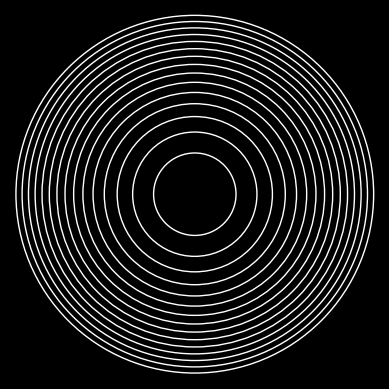

In [30]:
import matplotlib.pyplot as plt
import numpy as np


def draw_concentric_circles(initial_radius, area_diff, num_circles):
    # Initialize the figure and axis
    fig, ax = plt.subplots()
    ax.set_aspect("equal", "box")

    # Calculate and draw each circle
    radius = initial_radius
    for _ in range(num_circles):
        circle = plt.Circle((0, 0), radius, fill=False, edgecolor="white", linewidth=1)
        ax.add_artist(circle)

        # Calculate the next radius using the formula
        radius = np.sqrt(radius**2 + area_diff / np.pi)

    # Set axis limits and show plot
    ax.set_xlim([-radius, radius])
    ax.set_ylim([-radius, radius])
    ax.set_xticks([])  # Hide xticks
    ax.set_yticks([])  # Hide yticks
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(
        False
    )  # plt.title("Concentric Circles with Equal Area Differences")
    ax.set_facecolor("black")
    fig.patch.set_facecolor("black")
    plt.savefig("concentric_circle.png", bbox_inches="tight")


# Draw concentric circles starting with an initial radius of 1, area difference of 10, and 10 circles
draw_concentric_circles(5, 100, 15)